In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import sklearn as skl
import seaborn as sns
from scipy import signal

In [2]:
## Read the text files from the path argument
def read_textfiles(path):
    poss_columns = ['Lenkradwin', 'Lenkmoment', 'Fahrgeschw', 'Querbeschl', 'Giergeschw', 'Wankwinkel', 'Radius']
    files = sorted(os.listdir(path))
    print("No. of files to be processed are: ", len(files))
    count  = 0
    data = []
    dup_path = path
    for each_file in files:
        dup_path += each_file
#         print(dup_path)
        print(count, end=',')
#         data.append(pd.read_csv(dup_path, sep = '\t', engine = 'python', decimal = ',', skiprows = 40, usecols = poss_columns)[2: ].apply(pd.to_numeric))
        data.append(pd.read_csv(dup_path, sep = '\t', engine = 'python', decimal = ',', skiprows = 40)[2: ].apply(pd.to_numeric))
        count += 1
        dup_path = path
    print("No. of files processed are: ", count)
    return data

In [3]:
## all files are stored as a list of dataframes
file_data = read_textfiles('/home/loki/MAS/R_D/Moses/Full_data/sk_folded/0031678-8801103(001)/')

No. of files to be processed are:  6
0,1,2,3,4,5,No. of files processed are:  6


### Preprocess data

In [4]:
removable_columns = ['L�ngsbesch', 'GPS_Status', 'Status_DIS', 'Status_TRK', 'GPS_FMS_St','Breitengrd', 'L�ngengrad', 
                     'Breitengrd', 'H�he', 'Fahrg_NULL', 'StWhl_AnglSpd', 'Odo', 'AirTemp_Outsd_Disp', 'AirTemp_Outsd',
                     'BrkPdl_Stat', 'Brk_Stat', 'FullBrk_Actv', 'BrkIntrvntn_Actv_ESP', 'ESP_CtrlLmp_Info',
                     'AccelPdlPosn_Raw', 'AccelPdlPosn', 'KickDnSw_Psd',  'TankLvl', 'TankLvl_Disp_V2', 'SupBat_Volt', 
                     'SupBat_Curr', 'StW_Trq_EPS', 'EPS_FtWhlAngl', 'EPS_FtWhlAngl_Offset', 'VehAccel_X_Offset',
                      'VehYawRateOffset_V2', 'BrkTrq_V2']
## Remove the columns whose values don't change
for each_file in range(len(file_data)):
    file_data[each_file] = file_data[each_file].drop(columns=removable_columns)
print(list(file_data[0]))
print(len(list(file_data[0])))
f2_p = file_data[2]

['Lenkradwin', 'Lenkmoment', 'Fahrgeschw', 'Schwimmwin', 'F_Spur_VL', 'F_Spur_VR', 'Querbeschl', 'Giergeschw', 'Nickwinkel', 'Wankwinkel', 'Gierwinkel', 'Nickgeschw', 'Wankgeschw', 'Hochbeschl', 'Fahrge_DIS', 'Schwim_MSP', 'Schwim_MHA', 'Radius', 'Fdiff_Spur', 'Lichtschra', 'LenkgeschM', 'StWhl_Angl', 'VehSpd_Disp', 'VehAccel_X_V2', 'VehAccel_Y_V2', 'VehAccel_Y_Offset', 'VehYawRate_Raw', 'WhlRPM_FL', 'WhlRPM_FR', 'WhlRPM_RL', 'WhlRPM_RR', 'EngRPM']
32


238256


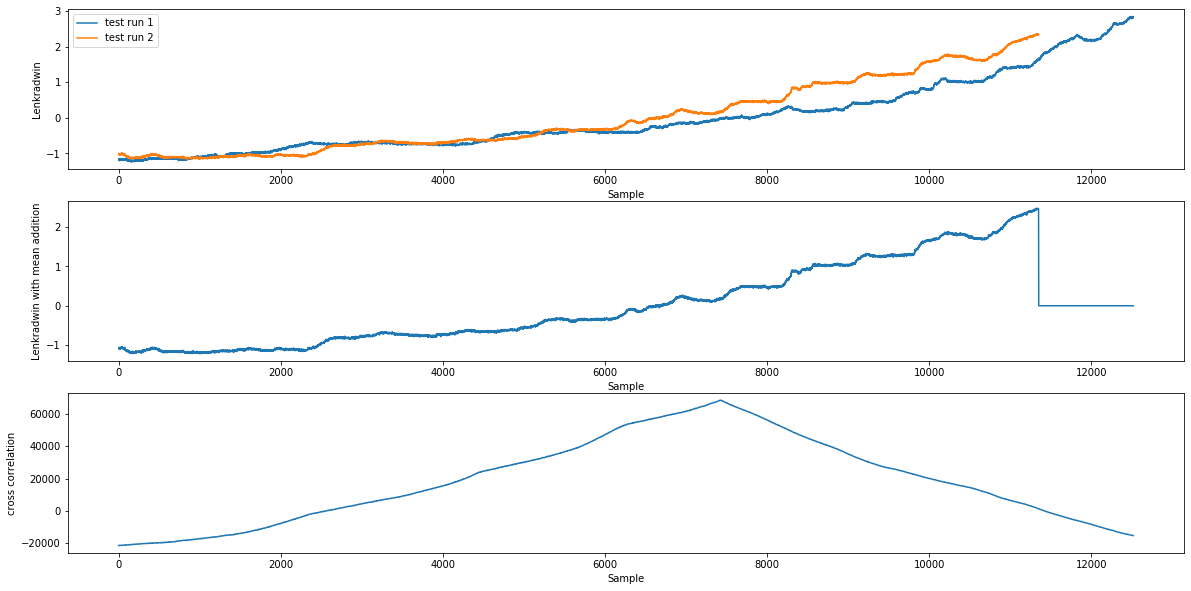

400112


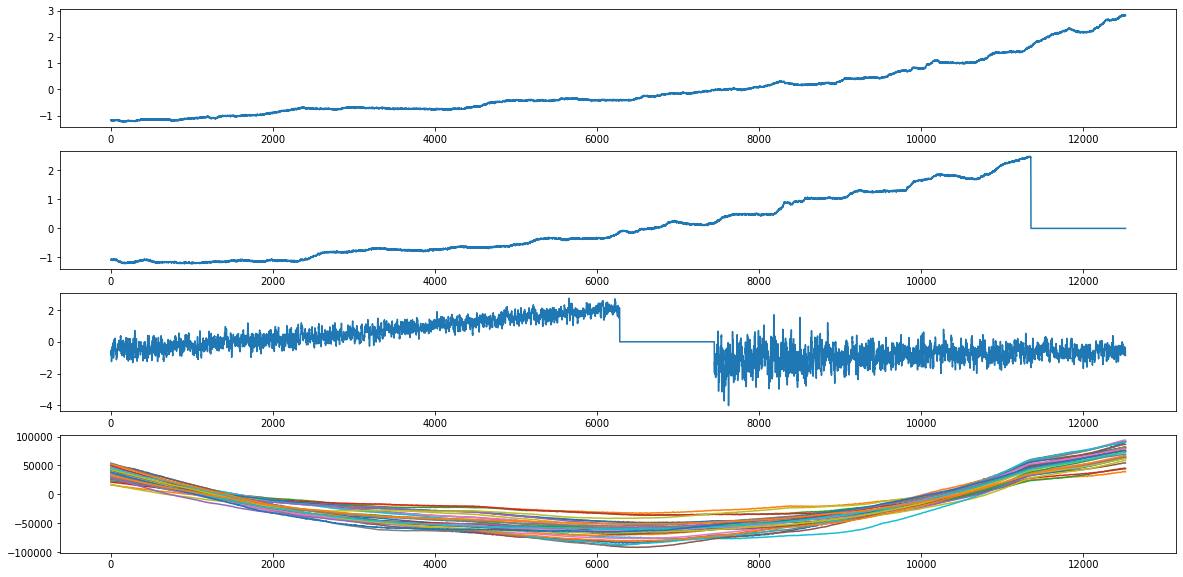

In [5]:

if len(file_data[0]) > len(file_data[2]):
    mean_value = np.mean(file_data[2], axis = 0)
    for  i in range(0, len(file_data[0])-len(file_data[2])):
        file_data[2] = file_data[2].append(mean_value, ignore_index = True)
else:
    mean_value = np.mean(file_data[0], axis = 0)
    for  i in range(0, len(file_data[2])-len(file_data[0])):
        file_data[0] = file_data[0].append(mean_value, ignore_index = True)
f0 = file_data[0].to_numpy()
f2 = file_data[2].to_numpy()
f0 = (f0-np.mean(f0, axis = 0))/np.std(f0, axis = 0)
f2 = (f2-np.mean(f2, axis = 0))/np.std(f2, axis = 0)
f2_p = f2_p.to_numpy()
f2_p = (f2_p-np.mean(f2_p, axis = 0))/np.std(f2_p, axis = 0)
correlated = signal.correlate(f0, f2, mode='same', method='auto')
lag = np.argmax(correlated)
print(lag)
plt.figure(figsize=(20,10))
plt.subplot(3, 1, 1)
plt.plot(f0[:, 0], label='test run 1')

plt.plot(f2_p[:, 0], label="test run 2")
plt.xlabel("Sample")
plt.ylabel("Lenkradwin")
plt.gca().legend()

plt.subplot(3, 1, 2)
plt.plot(f2[:, 0])
plt.xlabel("Sample")
plt.ylabel("Lenkradwin with mean addition")

plt.subplot(3, 1, 3)
plt.plot(correlated[:, 0])
plt.xlabel("Sample")
plt.ylabel("cross correlation")
plt.show()
f2_changed = np.roll(f2, shift=int(np.ceil(lag)))
correlated_new = signal.correlate(f0, f2_changed, mode='same', method='auto')
lag_new = np.argmax(correlated_new)
print(lag_new)
plt.figure(figsize=(20,10))
plt.subplot(4, 1, 1)
plt.plot(f0[:, 0])

plt.subplot(4, 1, 2)
plt.plot(f2[:, 0])
plt.subplot(4, 1, 3)
plt.plot(f2_changed[:, 0])
plt.subplot(4, 1, 4)
plt.plot(correlated_new)
plt.show()

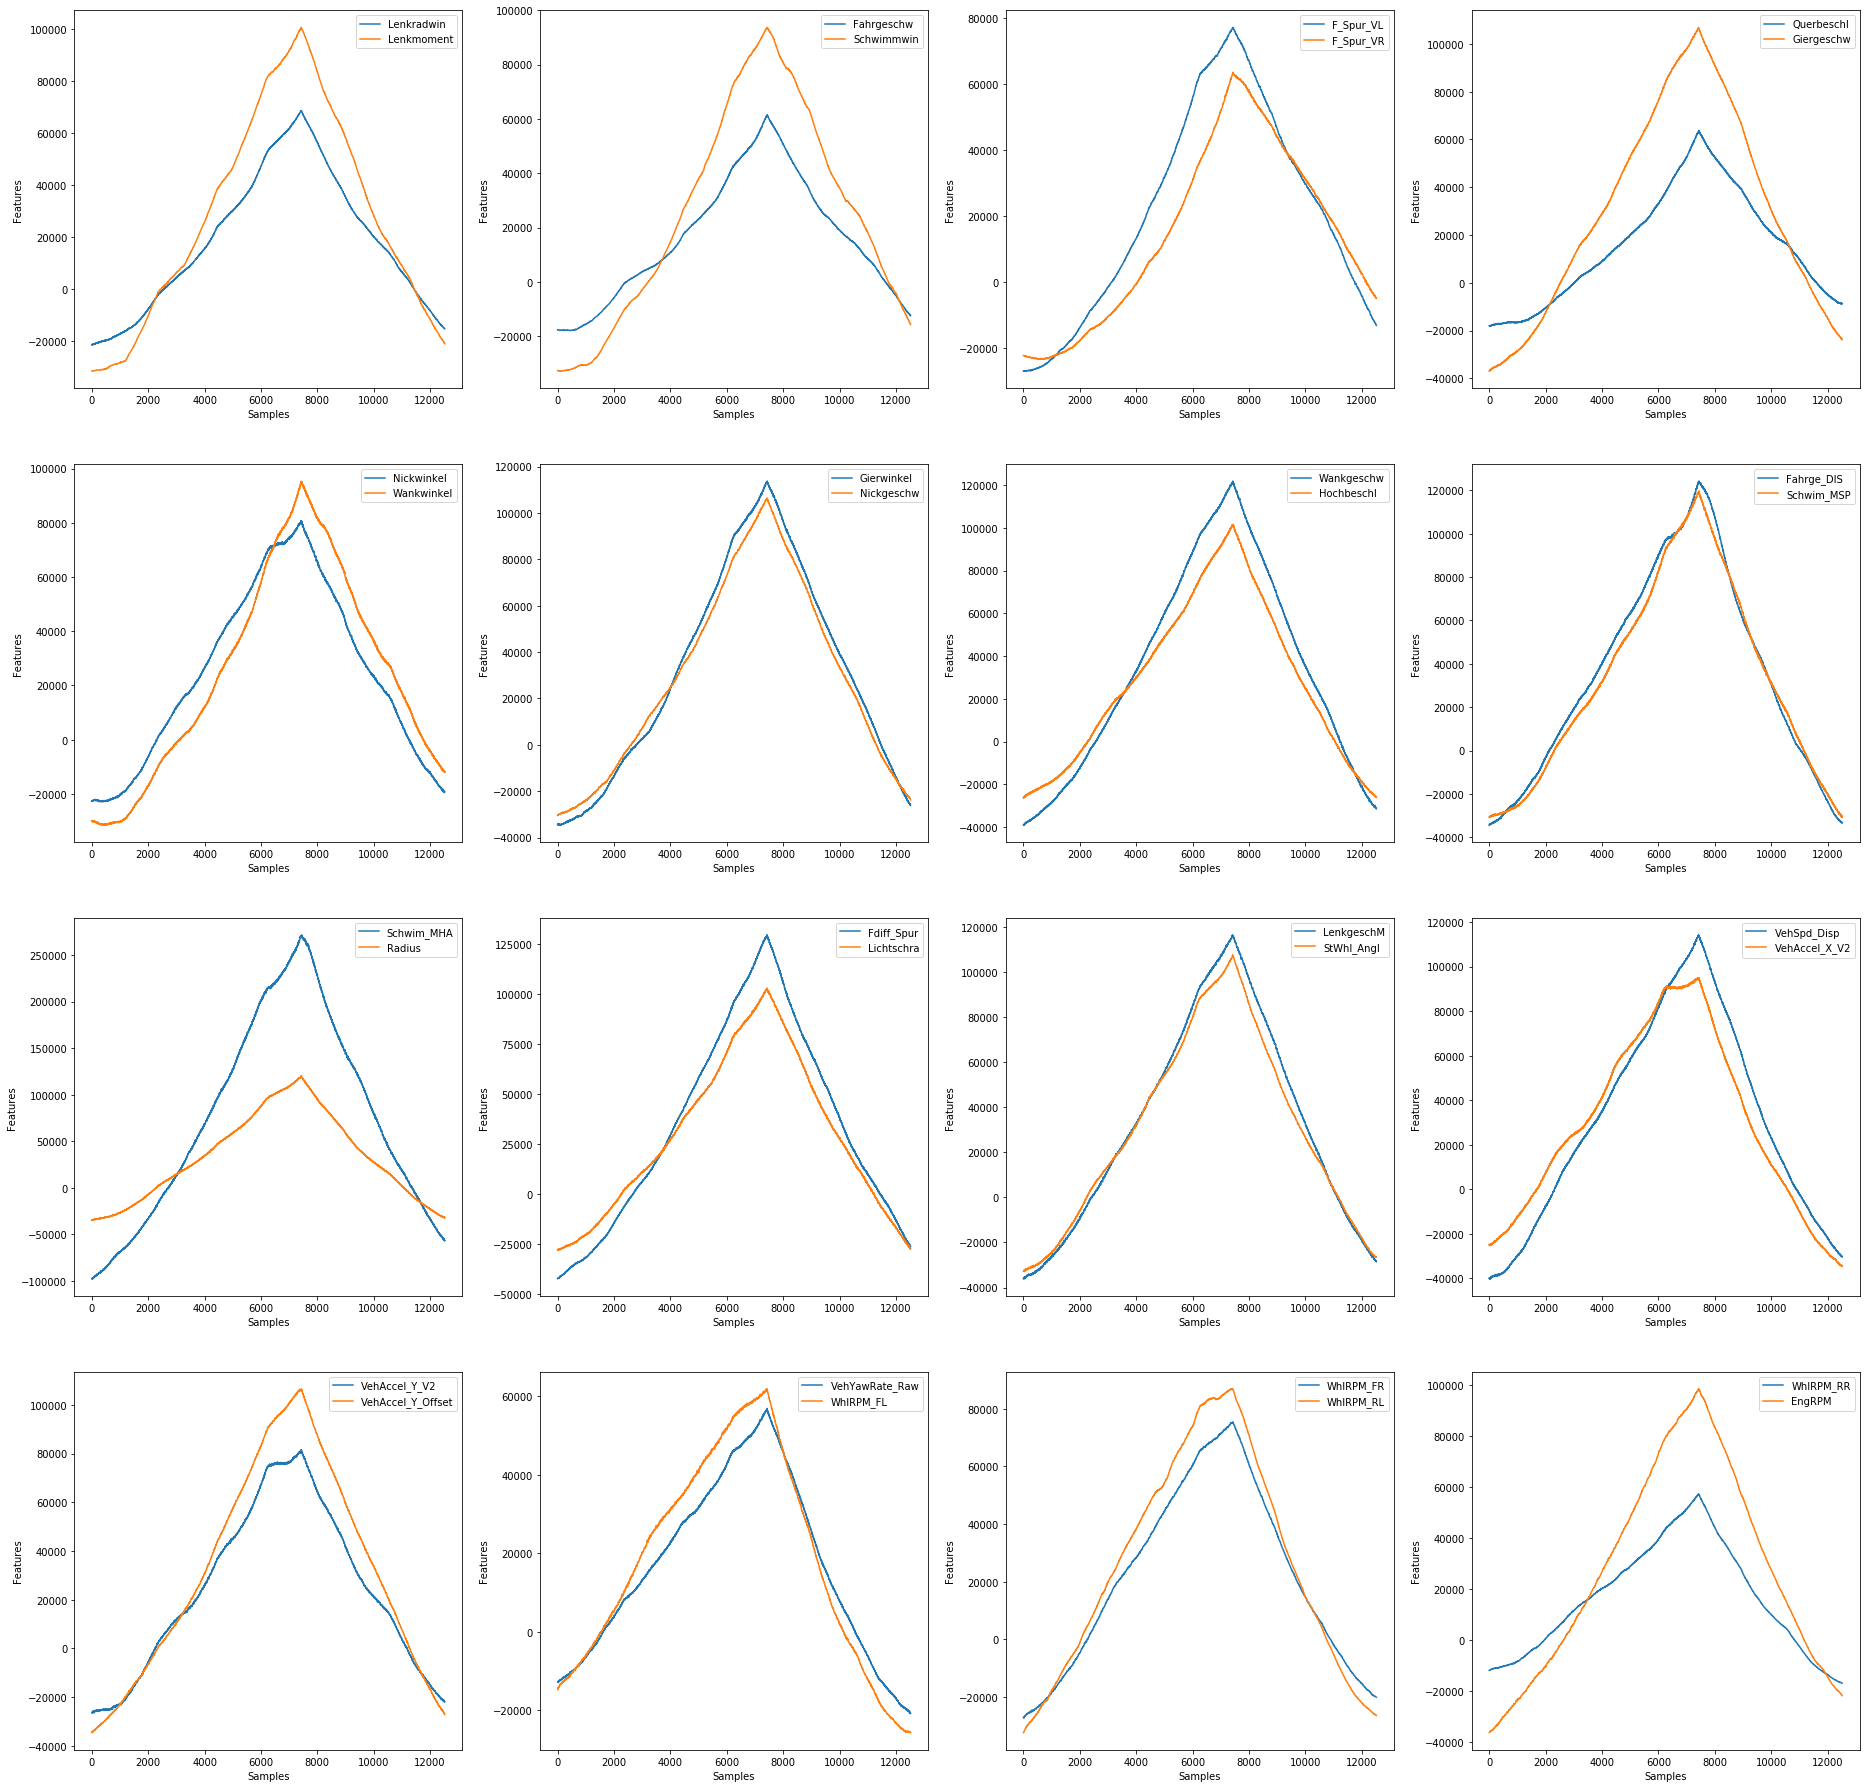

In [6]:
data_columns = list(file_data[0])
plt.figure(figsize=(32,32))
count = 1
for idx in range(0, len(data_columns)-1, 2):
    plt.subplot(4, 4, count)
    count += 1
    plt.plot(correlated[:, idx], label=data_columns[idx])
    plt.plot(correlated[:, idx+1], label=data_columns[idx+1])
    plt.xlabel("Samples")
    plt.ylabel("Features")
    plt.gca().legend()

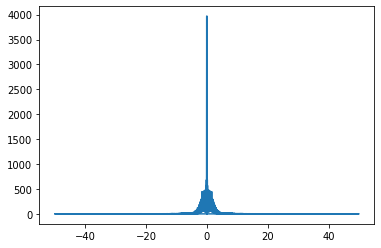

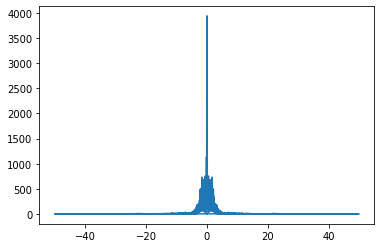

In [7]:
fft_signal = np.fft.fft(f0, axis = 0)
fft_2 = np.fft.fft(f2, axis = 0)
freq = np.fft.fftfreq(len(f0), d = 1/100)
plt.plot(freq, np.abs(fft_signal[:, 8]))
plt.show()
plt.plot(freq, np.abs(fft_2[:, 8]))
plt.show()


# Make acceleration on y axis:

In [26]:
def rolling_avg(data, win_size, verbose=True):
    # Moving average
    df = data.rolling(window=win_size).mean()
    df = df.drop(range(2, win_size+1), axis=0)
    y_acceleration = df['Querbeschl']
    x = np.polyfit(range(0, len(y_acceleration)), y_acceleration, deg = 1)
    data_new = df.divide(y_acceleration, axis=0)
    
    if verbose:
        print(x)
        plt.figure(figsize=(10, 10))
        plt.plot(y_acceleration, label="Querbeschleunigung")
        x_val = np.arange(0, len(y_acceleration))
        y_line = (x[0]*(x_val))+(x[1])
        plt.plot(y_line, c='k', label='1 degree poly')
        plt.ylabel("Querbeschl")
        plt.xlabel("Samples")
        plt.grid()
        plt.gca().legend()
        plt.show()
        plt.figure(figsize=(3, 3))
        plt.plot(range(len(y_acceleration)), df['Fahrgeschw'])
        plt.ylabel("Lenkradwin")
        plt.xlabel("Querbeschl")
        plt.grid()
        plt.show()
        print(np.where(y_acceleration == 0))
        columns = list(df)
        col_1 = columns[:len(columns)//2]
        col_2 = columns[len(columns)//2 : ]
        plt.figure(figsize=(20, 20))
        for index, column in enumerate(col_1):
            plt.subplot(4, 4, (index+1))
            plt.plot(data_new[column], label=column)
            plt.gca().legend()
            ylbl = column+"/querbeschl"
            plt.ylabel(ylbl)
            plt.xlabel("No. of samples")
            plt.grid()
        # plt.savefig("columns_1.png", edgecolor='k')
        plt.show()
        plt.figure(figsize=(20, 20))
        for index, column in enumerate(col_2):
            plt.subplot(4, 4, (index+1))
            plt.plot(data_new[column], label=column)
            plt.gca().legend()
            ylbl = column+"/querbeschl"
            plt.ylabel(ylbl)
            plt.xlabel("No. of samples")
            plt.grid()
        # plt.savefig("columns_2.png", edgecolor='k')
    return data_new

[ 6.14687349e-04 -1.21249328e+00]


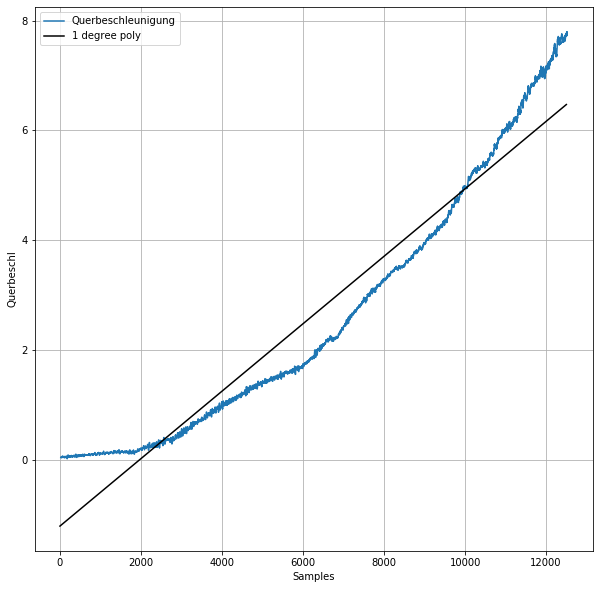

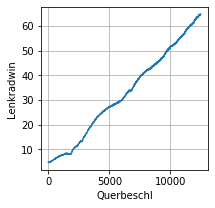

(array([], dtype=int64),)


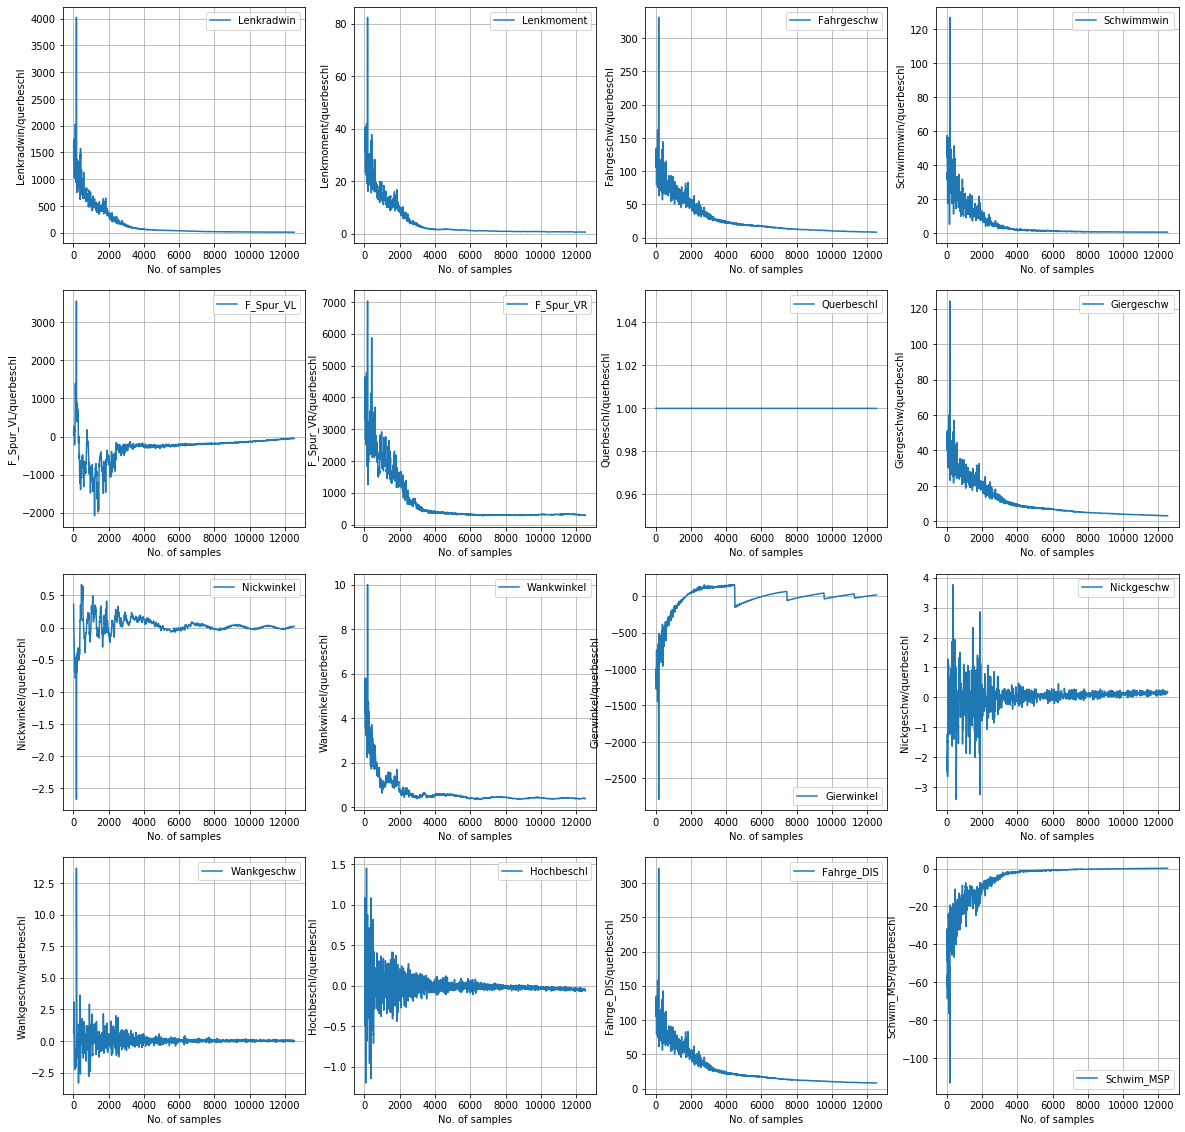

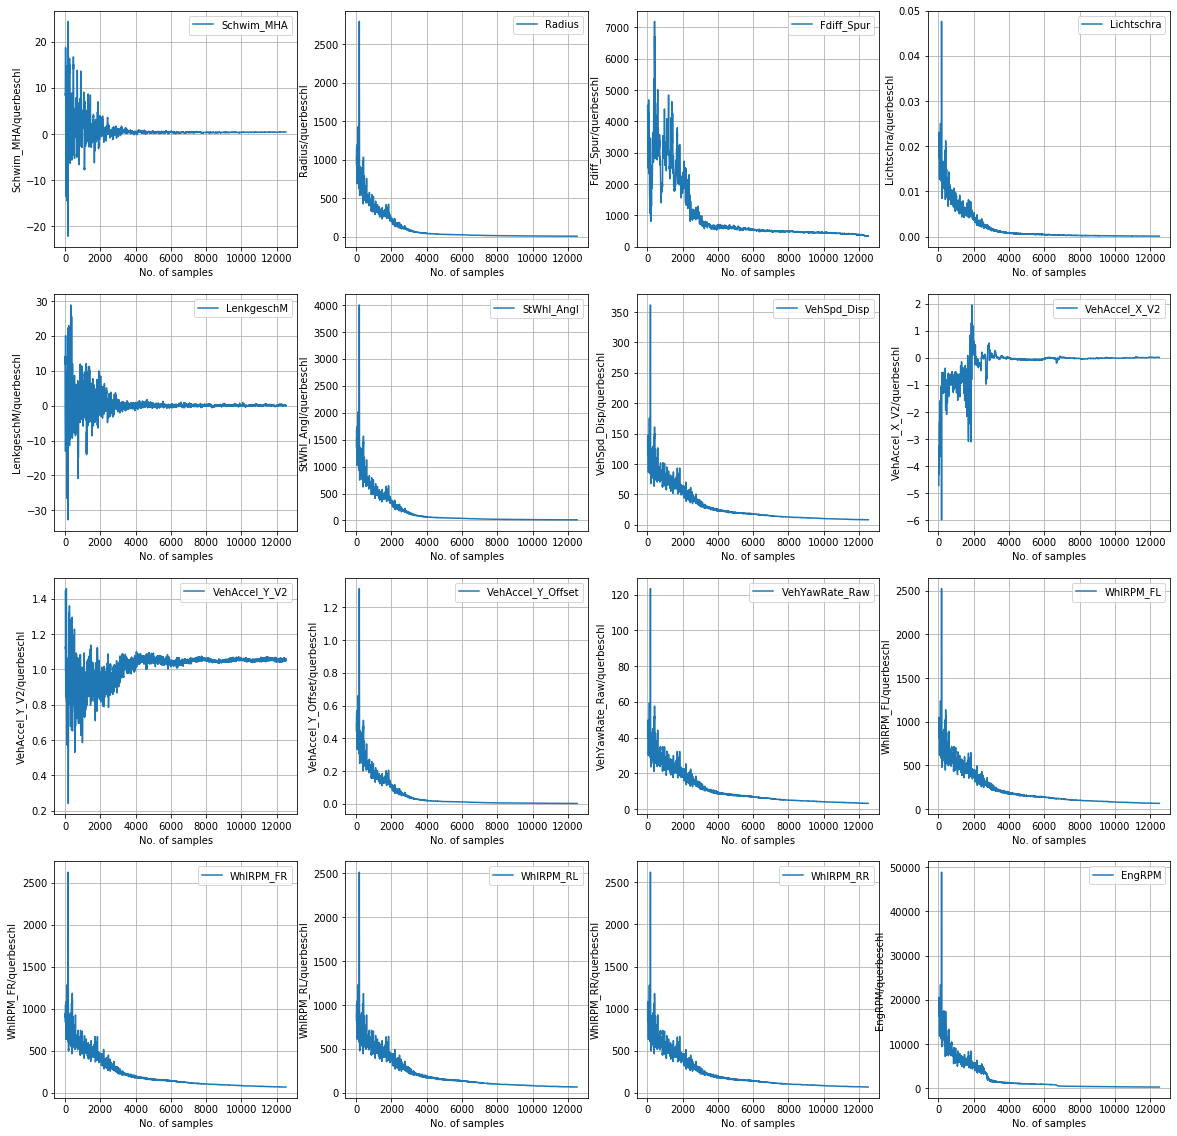

In [27]:
new_data_avg_1 = rolling_avg(file_data[0], 20)

## Without first 2000 values

In [10]:
def avg_remove_2000(data, win_size):
    # Moving average
    df = data.rolling(window=win_size).mean()
    df = df.drop(range(2, 2001), axis=0).reset_index()
    
    y_acceleration = df['Querbeschl']
    x = np.polyfit(range(0, len(y_acceleration)), y_acceleration, deg = 1)
    print(x)
    plt.figure(figsize=(3, 3))
    plt.plot(y_acceleration, label="Querbeschleunigung")
    x_val = np.arange(0, len(y_acceleration))
    y_line = (x[0]*(x_val))+x[1]
    plt.plot(y_line, c='k', label='1 degree poly')
    plt.ylabel("Querbeschl")
    plt.xlabel("Samples")
    plt.grid()
    plt.gca().legend()
    plt.show()
    plt.figure(figsize=(3, 3))
    plt.plot(y_acceleration, df['Lenkradwin'])
    plt.ylabel("Lenkradwin")
    plt.xlabel("Querbeschl")
    plt.grid()
    plt.show()
    print(np.where(y_acceleration == 0))
    y_acceleration = np.asarray(y_acceleration.tolist())
    for i in range(len(y_acceleration)):
        if y_acceleration[i] == 0:
            y_acceleration[i] += 0.0001
    #         y_acceleration[i] = np.mean(y_acceleration)
    print(np.where(y_acceleration == 0))
    data_new = df.divide(y_acceleration, axis=0)
    columns = list(df)
    col_1 = columns[:len(columns)//2]
    col_2 = columns[len(columns)//2 : ]
    plt.figure(figsize=(20, 20))
    for index, column in enumerate(col_1):
        plt.subplot(5, 5, (index+1))
        plt.plot(data_new[column], label=column)
        plt.gca().legend()
        ylbl = column+"/querbeschl"
        plt.ylabel(ylbl)
        plt.xlabel("No. of samples")
        plt.grid()
    # plt.savefig("columns_1.png", edgecolor='k')
    plt.show()
    plt.figure(figsize=(20, 20))
    for index, column in enumerate(col_2):
        plt.subplot(5, 5, (index+1))
        plt.plot(data_new[column], label=column)
        plt.gca().legend()
        ylbl = column+"/querbeschl"
        plt.ylabel(ylbl)
        plt.xlabel("No. of samples")
        plt.grid()
    # plt.savefig("columns_2.png", edgecolor='k')
    return df

[ 0.00070893 -0.62475589]


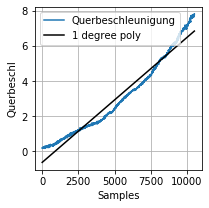

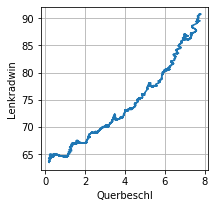

(array([], dtype=int64),)
(array([], dtype=int64),)


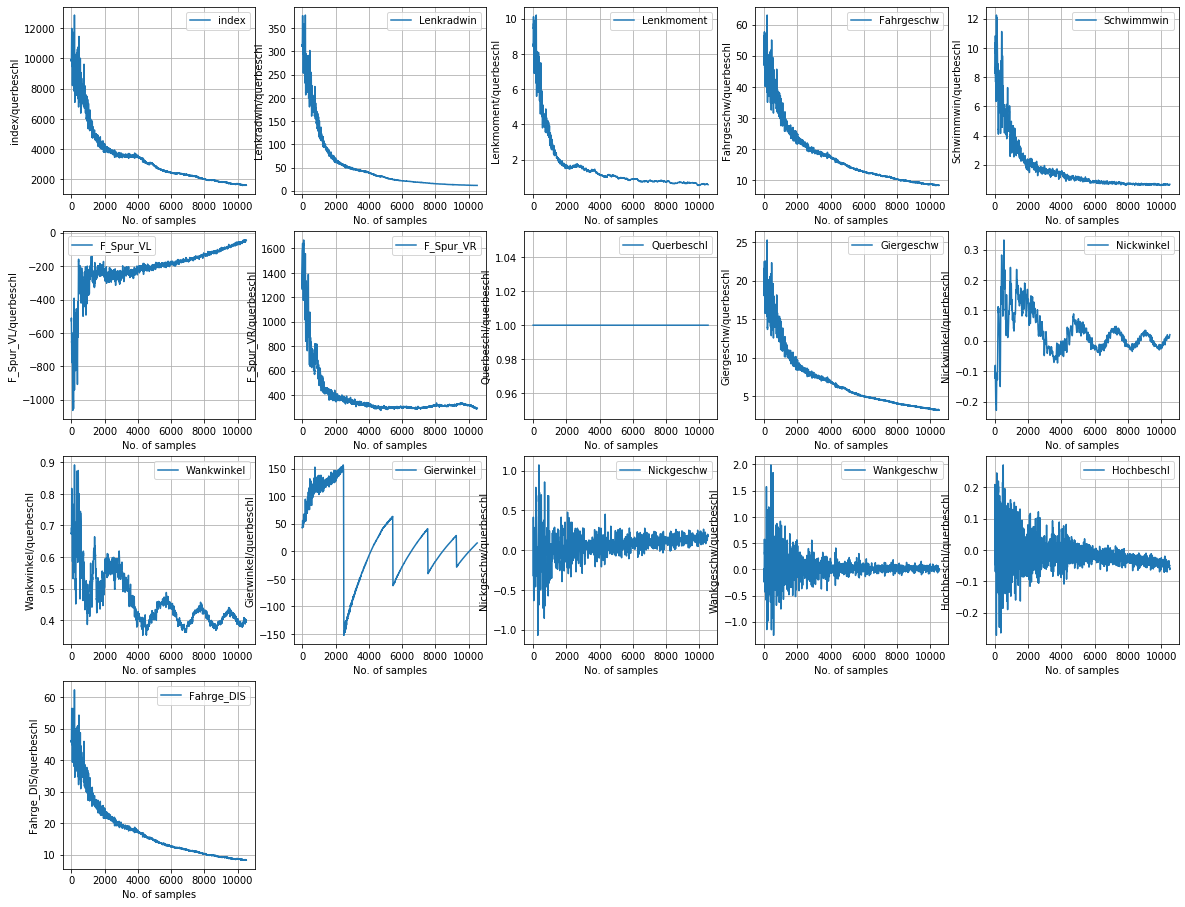

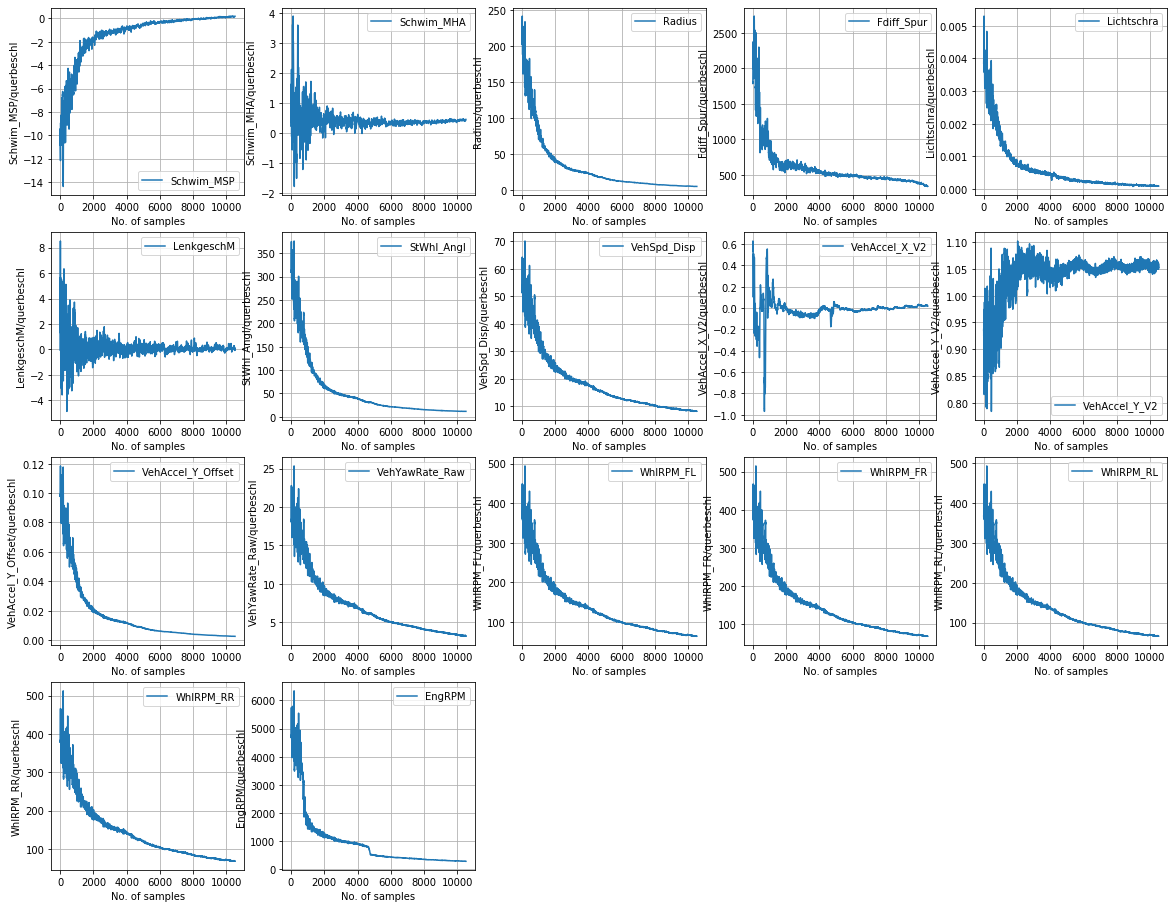

In [11]:
new_data_1 = avg_remove_2000(file_data[0], 20)

[nan nan]


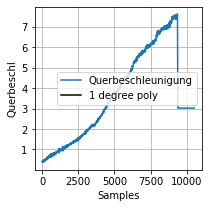

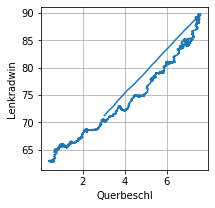

(array([], dtype=int64),)
(array([], dtype=int64),)


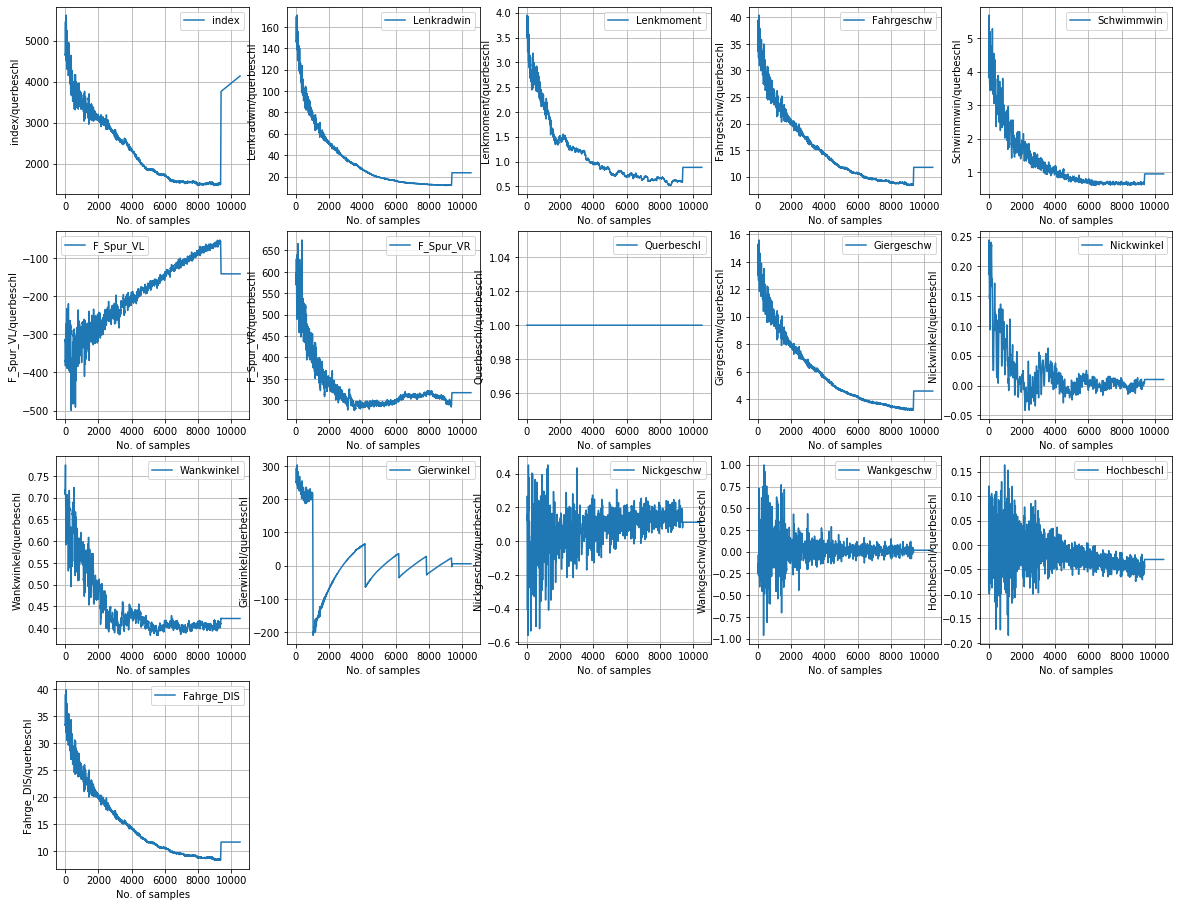

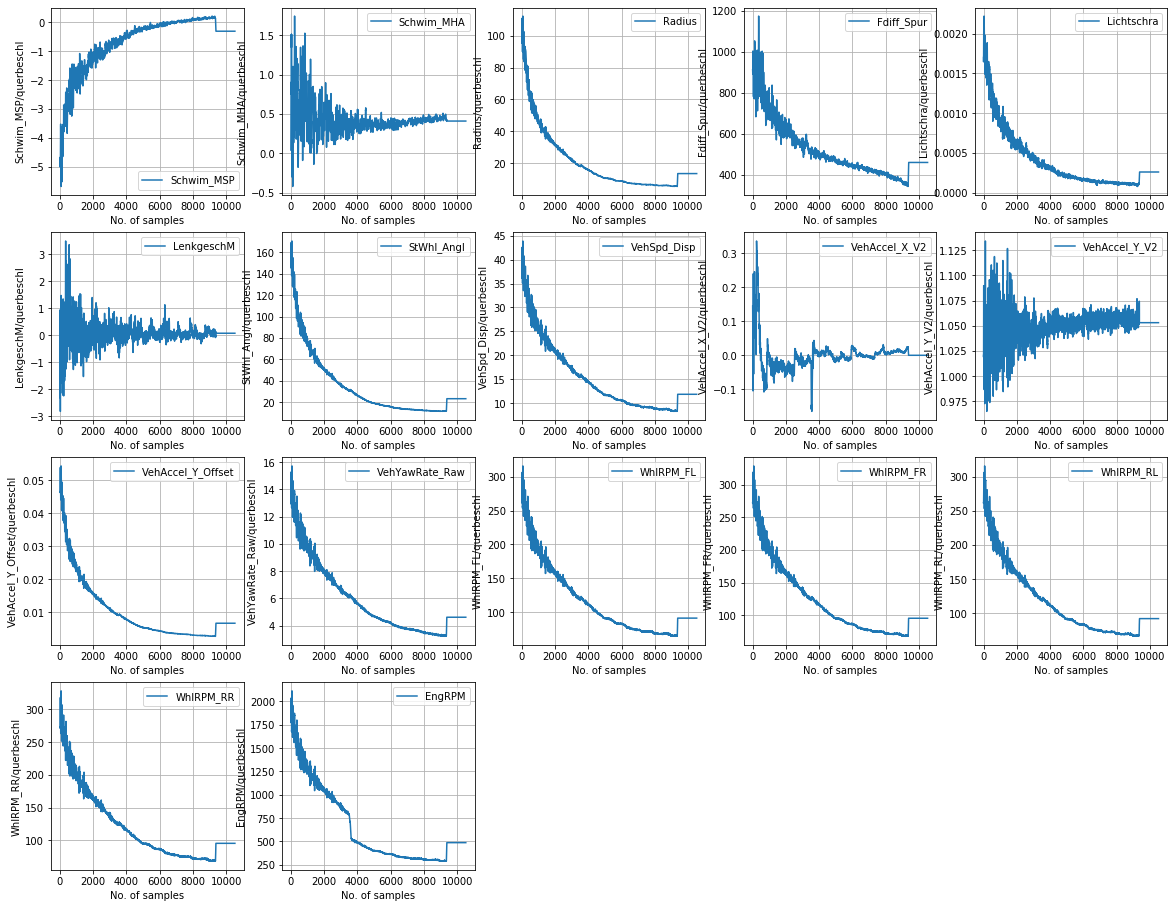

In [12]:
new_data_2 = avg_remove_2000(file_data[2], 20)

[ 0.00085438 -0.40759375]


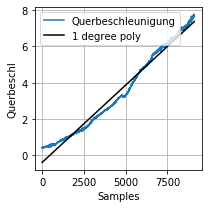

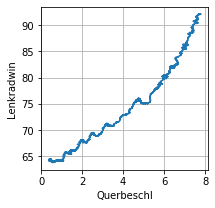

(array([], dtype=int64),)
(array([], dtype=int64),)


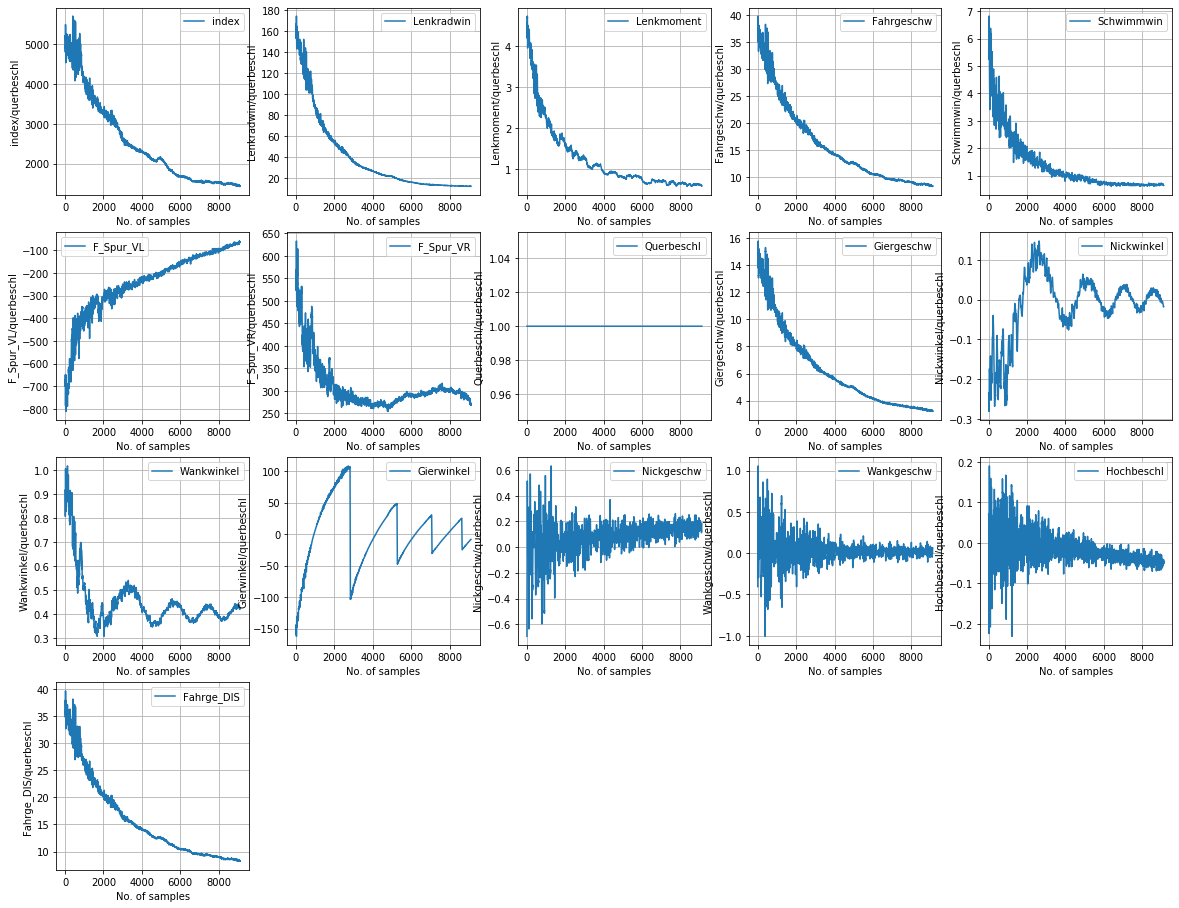

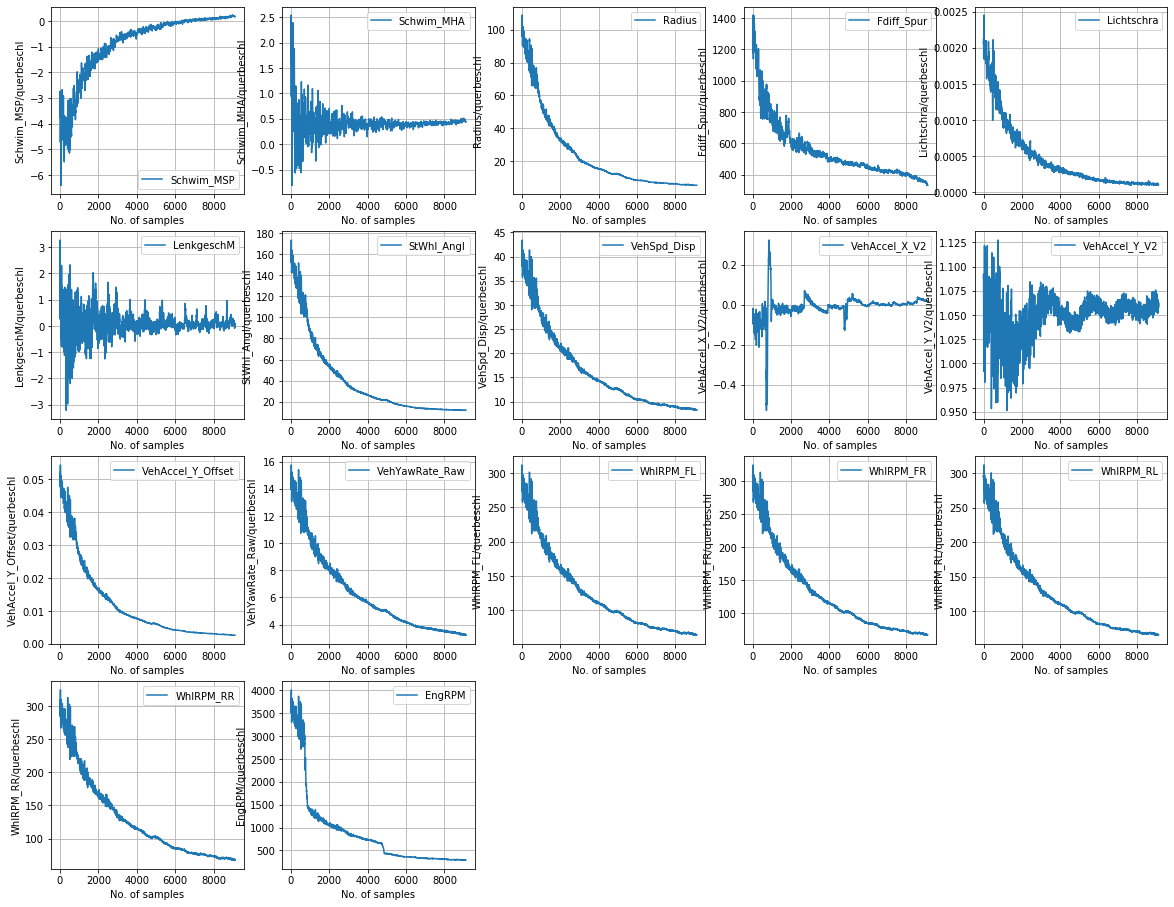

In [13]:
new_data_3 = avg_remove_2000(file_data[4], 20)

## Down Sampling:

In [14]:
import scipy

12501
12501
11093
9113


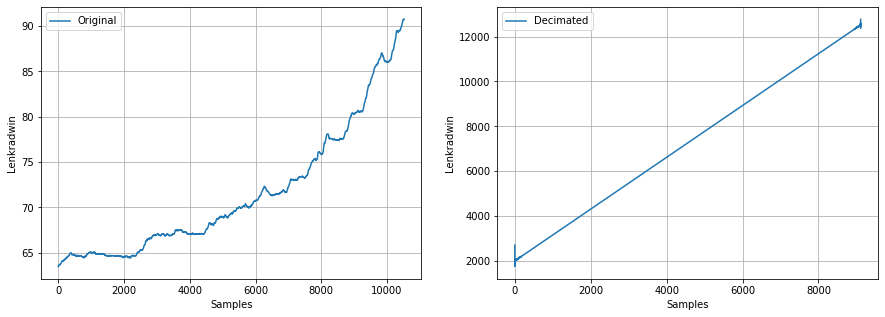


11093
11093


In [15]:
#print(len(file_data[0]))
#print(len(new_data_1))
#print()
#print(len(file_data[2]))
#print(len(new_data_2))
#print()
#print(len(file_data[4]))
#print(len(new_data_3))
#print()
win_size=20
data_1 = rolling_avg(file_data[0], win_size, verbose=False)
data_2 = rolling_avg(file_data[2], win_size, verbose=False)
data_3 = rolling_avg(file_data[4], win_size, verbose=False)
print(len(data_1))
print(len(data_2))
print(len(data_3))
decimated_1 = scipy.signal.resample(new_data_1, len(new_data_3))
print(len(decimated_1))
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(new_data_1['Lenkradwin'], label="Original")
plt.gca().legend()
plt.xlabel("Samples")
plt.ylabel("Lenkradwin")
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(decimated_1[:, 0], label="Decimated")
plt.gca().legend()
plt.xlabel("Samples")
plt.ylabel("Lenkradwin")
plt.grid()
plt.show()
print()
changed_1 = rolling_avg(file_data[0], len(data_1)-len(data_3)+win_size, verbose=False)
changed_2 = rolling_avg(file_data[2], len(data_2)-len(data_3)+win_size, verbose=False)
print(len(changed_1))
print(len(changed_2))

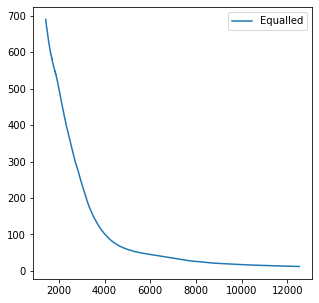

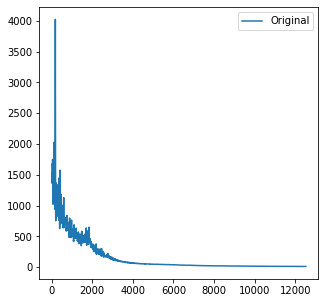

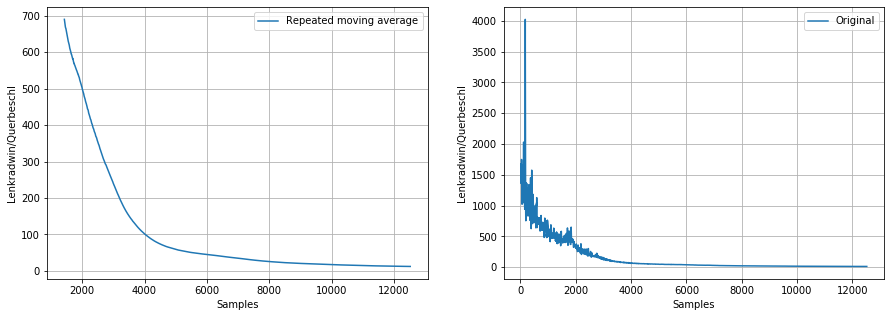

In [16]:
plt.figure(figsize=(5, 5))
plt.plot(changed_1["Lenkradwin"], label="Equalled")
plt.gca().legend()
plt.show()
plt.figure(figsize=(5, 5))
plt.plot(data_1["Lenkradwin"], label="Original")
plt.gca().legend()
plt.show()
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(changed_1['Lenkradwin'], label="Repeated moving average")
plt.gca().legend()
plt.xlabel("Samples")
plt.ylabel("Lenkradwin/Querbeschl")
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(data_1["Lenkradwin"], label="Original")
plt.gca().legend()
plt.xlabel("Samples")
plt.ylabel("Lenkradwin/Querbeschl")
plt.grid()
plt.show()
print()

## PCA on the querbeschl data

In [17]:
data_new = data_new.drop(columns=['Querbeschl'])

NameError: name 'data_new' is not defined

In [ ]:
# Applying PCA
np_data = data_new.to_numpy()
# print(np.isinf(np_data).any())
# print(np.nanstd(np_data, axis = 0))
#np_data_std = (np_data-np.mean(np_data, axis = 0))/np.std(np_data, axis = 0)
mp_data_std = np_data
cov_matrx = (np_data_std-np.mean(np_data_std, axis =0)).T.dot(np_data_std-np.mean(np_data_std, axis =0)) / (np_data_std.shape[0]-1)
eigen_vals, eigen_vecs = np.linalg.eig(cov_matrx)
eigen_tuples = [(eigen_vals[idx], eigen_vecs[:, idx]) for idx in range(len(eigen_vals))]
eigen_tuples.sort(key = lambda x:x[0], reverse=True)
eigen_vals_sum = sum(eigen_vals)
print("Eigen values sum: \n", eigen_vals_sum)
exp_variance = [(eigen_val*100)/eigen_vals_sum for eigen_val in sorted(eigen_vals, reverse=True)]
cum_exp_variance = np.cumsum(exp_variance)
print()
print("Explained variance: \n", exp_variance)
print()
print("Cumulative variance: \n", cum_exp_variance)
no_dim = 0
for val in cum_exp_variance:
    if val < 99:
        no_dim += 1
    else:
        break
W_matrix = np.zeros(shape = (len(eigen_vals),1))
for idx, each_tuple in enumerate(eigen_tuples):
    if idx < no_dim:
        W_matrix = np.hstack((W_matrix, each_tuple[1].reshape(len(eigen_vals),1)))
W_matrix = W_matrix[: ,1:]
plt.figure(figsize=(15, 10))
plt.bar(range(len(exp_variance)), exp_variance, alpha=0.5, align='center', label = 'Individual PC significance')
plt.step(range(len(cum_exp_variance)), cum_exp_variance, where = 'mid', label = 'Cumulative PC significance', c= 'r')
plt.xlabel("Pricipal Componenets")
plt.ylabel("Explained variance ratio")
plt.gca().legend()
plt.grid()
plt.show()
print("W matrix shape: ")
print(W_matrix.shape)

In [ ]:
plt.figure(figsize=(30, 30))
sns.heatmap(cov_matrx, xticklabels=list(data_new), yticklabels=list(data_new), annot=True)
plt.savefig("Covariance_mit_Querbeschl.png", edgecolor='k')
plt.show()

In [ ]:
np_data_std_projected = np_data_std.dot(W_matrix)
print(np_data_std_projected.shape)

In [ ]:
row, col = np_data_std_projected.shape
fig = plt.figure(figsize=(15, 10))
for idx in range(0, col):
    plt.subplot(col, 1, idx+1)
    plt.plot(range(0, row), np_data_std_projected[:, idx])
    plt.xlabel("Sample")
    ylbl = "PC "+str(idx+1)
    plt.ylabel(ylbl)
    plt.grid()
title = "PCA with "+str(no_dim)+" Principal Components"
fig.suptitle(title)
plt.show()
plt.figure(figsize=(10, 10))
plt.scatter(np_data_std_projected[:, 0], np_data_std_projected[:, 1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PC1 vs PC2")
plt.show()
plt.figure(figsize=(10, 10))
plt.scatter(np_data_std_projected[:, 1], np_data_std_projected[:, 2])
plt.xlabel("PC2")
plt.ylabel("PC3")
plt.title("PC2 vs PC3")
plt.show()
plt.figure(figsize=(10, 10))
plt.scatter(np_data_std_projected[:, 2], np_data_std_projected[:, 1])
plt.xlabel("PC3")
plt.ylabel("PC1")
plt.title("PC3 vs PC1")
plt.show()
print(np_data_std_projected[:, 0].shape)
print(np_data_std_projected[:, 1].shape)
print(np_data_std_projected[:, 2].shape)